In [ ]:
import math
from typing import List
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import string

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [137]:
def plot_surprisals(words:List[str], surprisals_df):
    num_words = len(words)
    cols = min(num_words, 3)
    rows = math.ceil(num_words / cols)

    plt.style.use('ggplot')
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = np.atleast_2d(axs)

    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word].iloc[1:]  # mention this
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        ax = axs[i//cols, i%cols]
        ax.plot(word_data['Steps'], word_data['MeanSurprisal'], marker='o')
        ax.set_title(f'"{word}"')
        ax.set_xlabel('BERT steps (log10)')
        ax.set_ylabel('Mean surprisal')
        ax.set_xscale('log')
        ax.invert_yaxis()

    # Remove empty subplots
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()


In [10]:
wikitext_surprisals = '../sample_data/wikitext/bert_surprisals.txt'
chang_bergen_surprisals = '../r_code/tacl_data/lm_data/bert_surprisals.txt'
bert_surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [11]:
bert_surprisals = (bert_surprisals
    .sort_values(['Token', 'Steps'])
    .groupby('Token')
    .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0), 
                              StdevSurprisalDiff = x['StdevSurprisal'].diff().fillna(0)))
    .reset_index(drop=True))

bert_surprisals.insert(0, 'Token', bert_surprisals.pop('Token'))
bert_surprisals

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff
0,a,0,3451,14.201838,0.386763,0.000000,512,0.000000,0.000000
1,a,20000,0,1.452711,1.769657,0.671875,512,-12.749128,1.382895
2,a,40000,0,1.050805,1.615932,0.773438,512,-0.401906,-0.153725
3,a,60000,0,0.964041,1.519993,0.789062,512,-0.086764,-0.095940
4,a,80000,0,0.926614,1.614722,0.787109,512,-0.037427,0.094729
...,...,...,...,...,...,...,...,...,...
7129,your,1600000,1,1.894058,2.084364,0.461538,13,-0.144634,0.085364
7130,your,1700000,0,1.733878,1.960023,0.615385,13,-0.160180,-0.124341
7131,your,1800000,0,1.719849,2.018352,0.692308,13,-0.014029,0.058329
7132,your,1900000,0,1.761835,2.017625,0.692308,13,0.041987,-0.000728


In [12]:
import nltk

nltk.download('averaged_perceptron_tagger')

word = 'run'
pos = nltk.pos_tag([word])
print(pos)

[('run', 'VB')]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nshafiabadi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
# def plot_df(word, df):
#     word_data = df[df['Token'] == word]
#     word_data.plot(x='Steps', y='MeanSurprisal', logx=True, title=f'"{word}"').set_ylim(df['MeanSurprisal'].max(), df['MeanSurprisal'].min())


# plot_df('your', bert_surprisals)

### Most vs least frequent words

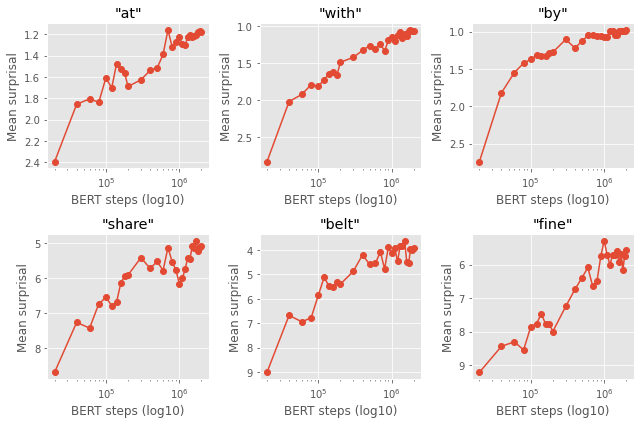

In [138]:
frequent = bert_surprisals[bert_surprisals['NumExamples'] == 512]
non_frequent = bert_surprisals[bert_surprisals['NumExamples'] == 8]

plot_surprisals(
    frequent['Token'].drop_duplicates().sample(3).tolist() + non_frequent['Token'].drop_duplicates().sample(3).tolist(), 
    bert_surprisals
    )

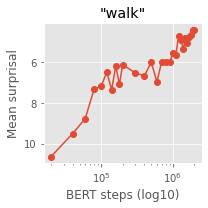

In [139]:
plot_surprisals(['walk'], bert_surprisals)

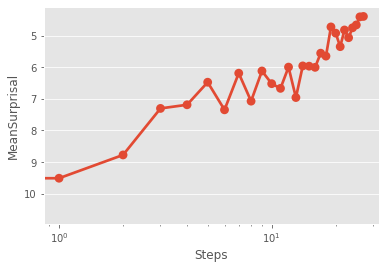

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_with_sns(word, df):
    plt.style.use('ggplot')
    word_data = df[df['Token'] == word].iloc[1:]
    ax = sns.pointplot(data=word_data,
                x='Steps',
                y='MeanSurprisal')
    ax.set_xscale('log')
    ax.invert_yaxis()

plot_with_sns('walk', bert_surprisals)

### Corpus-level surprisals 

(6.5, 2.884962031996347)

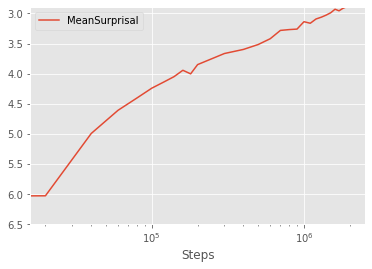

In [17]:
# for each step, average surprisal across all words

avg_surprisals = bert_surprisals.groupby('Steps')['MeanSurprisal'].mean().reset_index()
avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True).set_ylim(6.5, avg_surprisals['MeanSurprisal'].min())

In [18]:
# plot_surprisals(bert_surprisals['Token'].drop_duplicates().tolist(), bert_surprisals)

### Top 5 highest absolute diffs

In [19]:
highest_abs_diffs = bert_surprisals.loc[bert_surprisals['MeanSurprisalDiff'].abs().nlargest(5).index]
highest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff
6004,the,20000,0,0.781342,1.324811,0.886719,512,-15.236831,0.945859
6613,was,20000,0,1.192383,1.659401,0.789062,512,-14.026222,1.327233
3481,is,20000,0,1.775125,2.488918,0.690141,426,-13.900096,2.059086
610,be,20000,0,0.894825,1.832280,0.876133,331,-13.769206,1.415900
1799,did,20000,0,1.840310,2.702644,0.710526,114,-13.755656,2.364045


In [140]:
bert_surprisals.loc[bert_surprisals['MeanSurprisalDiff'].nlargest(5).index]

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff
5586,sit,1000000,15,6.399766,4.864535,0.333333,9,1.832698,0.310599
1459,chin,180000,33,8.215579,2.598957,0.000000,8,1.821589,0.132145
564,ball,500000,1,7.285607,7.719857,0.428571,28,1.643472,1.000957
5950,talk,100000,7,5.681591,4.063425,0.333333,9,1.592398,1.266768
1467,chin,900000,2,4.869381,2.738920,0.000000,8,1.532854,0.624547


In [ ]:
# for each time step, look for the n largest and n smallest

### Words with different POS

In [97]:
def get_pos_tags(doc_path):
    with open(doc_path, 'r') as file:
        doc = file.read()
        tokens = word_tokenize(doc)     # use spacy instead 
        tokens = [token.lower() for token in tokens if token not in string.punctuation]        
        pos_tags = nltk.pos_tag(tokens)
        
        pos_dict = {}
        for token, pos in pos_tags:
            if token in pos_dict and not pos in pos_dict[token]:
                pos_dict[token].append(pos)
            else:
                pos_dict[token] = [pos]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['Token', 'POS'])

In [93]:
document = "../sample_data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

,Token,POS
0,robert,"[JJ, NN]"
1,boulter,[NN]
2,is,[VBZ]
3,an,[DT]
4,english,[JJ]
...,...,...
18728,fatty,[JJ]
18729,parlayed,[VBD]
18730,credibility,[NN]
18731,ronnie,[JJ]


In [113]:
merged_df = bert_surprisals.merge(pos_tags, on='Token', how='left')
merged_df

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
0,a,0,3451,14.201838,0.386763,0.000000,512,0.000000,0.000000,[DT]
1,a,20000,0,1.452711,1.769657,0.671875,512,-12.749128,1.382895,[DT]
2,a,40000,0,1.050805,1.615932,0.773438,512,-0.401906,-0.153725,[DT]
3,a,60000,0,0.964041,1.519993,0.789062,512,-0.086764,-0.095940,[DT]
4,a,80000,0,0.926614,1.614722,0.787109,512,-0.037427,0.094729,[DT]
...,...,...,...,...,...,...,...,...,...,...
7129,your,1600000,1,1.894058,2.084364,0.461538,13,-0.144634,0.085364,[PRP$]
7130,your,1700000,0,1.733878,1.960023,0.615385,13,-0.160180,-0.124341,[PRP$]
7131,your,1800000,0,1.719849,2.018352,0.692308,13,-0.014029,0.058329,[PRP$]
7132,your,1900000,0,1.761835,2.017625,0.692308,13,0.041987,-0.000728,[PRP$]


In [116]:
merged_df[merged_df['POS'].isna()]['Token'].drop_duplicates().tolist()

# Why are there words is bert_surprisals that aren't in pos_tags, when both dfs have been created from the same document?

['ant', 'bat', 'cat', 'hi']

In [117]:
pos_tags[pos_tags['Token'] == 'hi']

,Token,POS


In [118]:
merged_df = merged_df.dropna()
merged_df[merged_df['POS'].isna()]['Token'].drop_duplicates().tolist()

[]

In [119]:
all_pos_tags = [pos for pos_list in merged_df['POS'] if isinstance(pos_list, list) for pos in pos_list]
set(all_pos_tags)

{'CC',
 'DT',
 'EX',
 'IN',
 'JJ',
 'JJR',
 'MD',
 'NN',
 'NNS',
 'PRP',
 'PRP$',
 'RB',
 'RP',
 'TO',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WRB'}

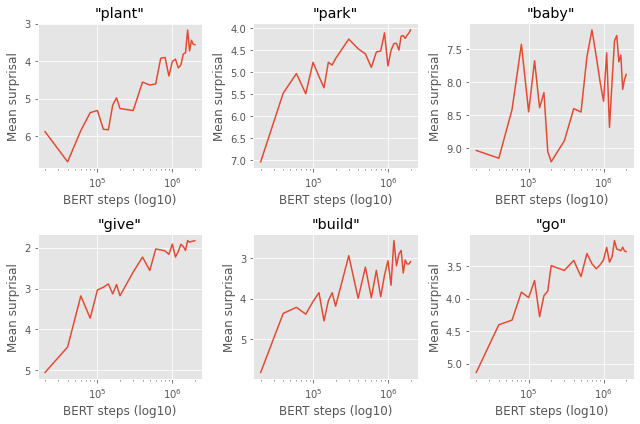

In [120]:
exclusive_NN = merged_df[merged_df['POS'].apply(lambda pos_list: 'NN' in pos_list and 'VB' not in pos_list)]
exclusive_VB = merged_df[merged_df['POS'].apply(lambda pos_list: 'VB' in pos_list and 'NN' not in pos_list)]

plot_surprisals(
    exclusive_NN['Token'].drop_duplicates().sample(3).tolist() + exclusive_VB['Token'].drop_duplicates().sample(3).tolist(), 
    merged_df
    )

(7.5, 3.60816396754465)

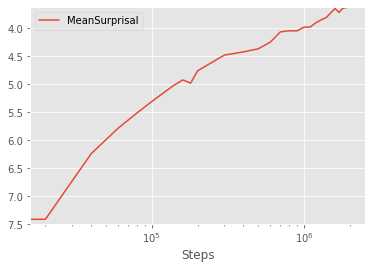

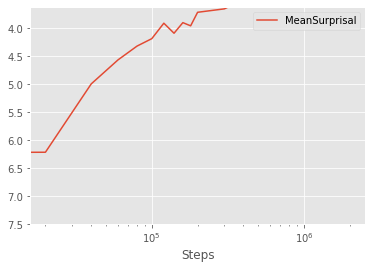

In [136]:
# for each step, average surprisal across all words with 'NN' tag vs average surprisal across all words with 'VB' tag

NN_avg_surprisals = exclusive_NN.groupby('Steps')['MeanSurprisal'].mean().reset_index()
NN_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True).set_ylim(7.5, avg_surprisals['MeanSurprisal'].min())

VB_avg_surprisals = exclusive_VB.groupby('Steps')['MeanSurprisal'].mean().reset_index()
VB_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True).set_ylim(7.5, avg_surprisals['MeanSurprisal'].min())